# 2030 분류 모델

In [1]:
import pandas as pd
import numpy as np
import re
# 형태소 분류 태그
from konlpy.tag import Okt
import pickle
# 학습-테스트용으로 나누기
from sklearn.model_selection import train_test_split
# 로지스틱회귀로 분류분석 진행하기
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
# 교차검증: 결과데이터를 보고 각 클래스가 균등한 비율로 들어있게끔 나눈다.
from sklearn.model_selection import StratifiedKFold
# 그리드 서치
from sklearn.model_selection import GridSearchCV


# 평가 방법
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 교차검증 함수
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

## 1. 2030데이터와 언론사 수집 데이터 합치기

- Train data
    - 4.7 보궐선거 데이터
- Test data
    - 대선을 위해 수집한 데이터
    
- 제목 2030이 포함된 데이터는 빼기

In [67]:
total_df = pd.read_csv('data/data_2030_dataset.csv')
total_df

,Comment,is2030
0,내리막이 있으면 다시 오르막이 있는 법 예방주사라 생각하고 힘들 냅시다,1
1,마음을 얻으려면 조언을 을 모셔다가 들어보는 성의를 보여야 됩니다 도 아닌사람들이 ...,1
2,전 군대 전역 전까지는 보수를 지지했지만 대학에서 양극화에 관심을 가지면서 진보로 ...,1
3,몸 안에서 무엇인가 무너져 내린 기분그래도 힘내고 가야죠민주당은 뼈아픈 진단 새겨들...,1
4,네 죄송합니다 삭제하겠습니다,1
...,...,...
360429,황교안이 나라를이많큼말아먹구 파탄냈으면 평생니가할일은다한거다 제발 더이상나라망치지말...,0
360430,윤석열 힘내시고화이팅입니다,0
360431,황교안 대표 가 보수다,0
360432,황교안정직하고깨끋한애국자 불평하지말라 똑똑한것홍준표의원 검찰들이않다 주님준비된대통령...,0


In [9]:
def selectRandom(samples, n):
    import numpy as np
    return np.random.choice(samples, n)

In [11]:
total_df['is2030'].value_counts()

0    302432
1     58002
Name: is2030, dtype: int64

In [17]:
idx = selectRandom(total_df.index, 5000)
df3 = total_df.loc[idx]

In [18]:
df3['is2030'].value_counts()

0    4244
1     756
Name: is2030, dtype: int64

In [19]:
# 형태소 분리 tagger
def get_pos(x) :
    tagger = Okt() # Okt로 형태소 분리하기
    pos = tagger.pos(x) 
    results = [] # 형태소를 담을 리스트
    for i in pos:
        if i[1] != 'Josa': # 조사는 빼버리기
            results.append(f'{i[0]}/{i[1]}') #'단어/품사'의 형태로 리스트에 추가
        else:
            pass
    return results

In [31]:
index_vectorizer.vocabulary_

{'내리막/Noun': 35976,
 '있으면/Adjective': 165746,
 '다시/Noun': 45286,
 '오르막/Noun': 148982,
 '있는/Adjective': 164764,
 '법/Noun': 96694,
 '예방주사/Noun': 148341,
 '생각/Noun': 116809,
 '힘들/Adjective': 222290,
 '냅시다/Verb': 37059,
 '마음/Noun': 70834,
 '얻으려면/Verb': 143685,
 '조언/Noun': 175434,
 '모셔다가/Verb': 80870,
 '들어/Verb': 61001,
 '보는/Verb': 98776,
 '성의/Noun': 119655,
 '보여야/Verb': 99572,
 '됩니다/Verb': 57474,
 '도/Noun': 51776,
 '아닌/Adjective': 133312,
 '사람/Noun': 112754,
 '들/Suffix': 60389,
 '추측/Noun': 194784,
 '해서/Verb': 214234,
 '의/Noun': 157616,
 '이야기/Noun': 160506,
 '하는것/Verb': 208932,
 '자체/Noun': 167629,
 '문/Modifier': 84284,
 '제/Modifier': 174528,
 '의식/Noun': 157725,
 '없는/Adjective': 144607,
 '것/Noun': 11250,
 '입니다/Adjective': 163752,
 '아마추어/Noun': 133844,
 '몇번/Noun': 80214,
 '불러서/Verb': 104863,
 '보여주며/Verb': 99676,
 '실질/Noun': 126872,
 '적/Suffix': 171914,
 '좋다고/Adjective': 176742,
 '해요/Verb': 214741,
 '전/Noun': 172530,
 '군대/Noun': 17007,
 '전역/Noun': 172759,
 '보수/Noun': 99286,
 '지지/Noun': 183183,

In [32]:
# 단어당 몇개씩 들어 있는지에 대한 벡터를 생성
from sklearn.feature_extraction.text import CountVectorizer

index_vectorizer = CountVectorizer(tokenizer= lambda x : get_pos(x))
X = index_vectorizer.fit_transform(df3['Comment'].tolist())

In [21]:
# { 단어: 단어 인덱스 } 형태의 사전 확인
index_vectorizer.vocabulary_

{'내리막/Noun': 35976,
 '있으면/Adjective': 165746,
 '다시/Noun': 45286,
 '오르막/Noun': 148982,
 '있는/Adjective': 164764,
 '법/Noun': 96694,
 '예방주사/Noun': 148341,
 '생각/Noun': 116809,
 '힘들/Adjective': 222290,
 '냅시다/Verb': 37059,
 '마음/Noun': 70834,
 '얻으려면/Verb': 143685,
 '조언/Noun': 175434,
 '모셔다가/Verb': 80870,
 '들어/Verb': 61001,
 '보는/Verb': 98776,
 '성의/Noun': 119655,
 '보여야/Verb': 99572,
 '됩니다/Verb': 57474,
 '도/Noun': 51776,
 '아닌/Adjective': 133312,
 '사람/Noun': 112754,
 '들/Suffix': 60389,
 '추측/Noun': 194784,
 '해서/Verb': 214234,
 '의/Noun': 157616,
 '이야기/Noun': 160506,
 '하는것/Verb': 208932,
 '자체/Noun': 167629,
 '문/Modifier': 84284,
 '제/Modifier': 174528,
 '의식/Noun': 157725,
 '없는/Adjective': 144607,
 '것/Noun': 11250,
 '입니다/Adjective': 163752,
 '아마추어/Noun': 133844,
 '몇번/Noun': 80214,
 '불러서/Verb': 104863,
 '보여주며/Verb': 99676,
 '실질/Noun': 126872,
 '적/Suffix': 171914,
 '좋다고/Adjective': 176742,
 '해요/Verb': 214741,
 '전/Noun': 172530,
 '군대/Noun': 17007,
 '전역/Noun': 172759,
 '보수/Noun': 99286,
 '지지/Noun': 183183,

In [35]:
len(index_vectorizer.vocabulary_)

22945

In [34]:
print(XX[0])

get_pos(total_df['Comment'][0])

  (0, 21345)	0.1703858911284798
  (0, 20219)	0.15142744296131283
  (0, 18776)	0.14053401018960052
  (0, 18704)	0.15872994370051474
  (0, 18585)	0.14922092408852214
  (0, 17759)	0.14717561381794012
  (0, 17728)	0.1147460541483533
  (0, 17720)	0.14213492049059742
  (0, 17641)	0.27572906716521367
  (0, 17000)	0.1275651857021206
  (0, 16953)	0.22148842459800713
  (0, 16620)	0.1669867792031564
  (0, 16260)	0.17641079630612716
  (0, 14501)	0.18409730724548376
  (0, 14215)	0.12530826283659988
  (0, 12501)	0.1856116384814805
  (0, 11218)	0.1969680289873958
  (0, 10128)	0.1926505296961777
  (0, 8190)	0.12459463683864022
  (0, 7798)	0.1543274419002748
  (0, 7521)	0.1799911923932961
  (0, 7307)	0.2083244194933111
  (0, 7306)	0.21638190678625446
  (0, 7268)	0.1947261683998529
  (0, 6849)	0.23579578458511313
  (0, 5998)	0.13568803663085524
  (0, 5687)	0.12424452846457947
  (0, 4957)	0.20207454679914846
  (0, 4707)	0.1463975553074162
  (0, 3611)	0.2471521750910284
  (0, 1227)	0.15699691850726852
  (

['내리막/Noun',
 '있으면/Adjective',
 '다시/Noun',
 '오르막/Noun',
 '있는/Adjective',
 '법/Noun',
 '예방주사/Noun',
 '생각/Noun',
 '힘들/Adjective',
 '냅시다/Verb']

In [27]:
# 위에서 만든 형태소 벡터를 학습 데이터 벡터로 생성
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
XX = tfidf_vectorizer.fit_transform(XX)
print(X[0]) # (문장 번호, 단어 인덱스)    단어의 비중

  (0, 222290)	0.33229929846784273
  (0, 165746)	0.24421707888683727
  (0, 164764)	0.1719700363083868
  (0, 148982)	0.49234044786198994
  (0, 148341)	0.4299300029009989
  (0, 116809)	0.15624254554481035
  (0, 96694)	0.20727877984379303
  (0, 45286)	0.20150793453446375
  (0, 37059)	0.33400409122399016
  (0, 35976)	0.3918956123611123


In [36]:
# TF-IDF 저장
with open('model/tfidf_vectorizer_for_2030.dat','wb') as fp:
    pickle.dump(tfidf_vectorizer, fp)
print('저장완료')

저장완료


## 3. y값 구분

In [20]:
X

<360434x222748 sparse matrix of type '<class 'numpy.float64'>'
	with 7130985 stored elements in Compressed Sparse Row format>

In [38]:
# 2030인지 아닌지를 알 수 있는 값
y = df3['is2030']
y.value_counts()

0    4244
1     756
Name: is2030, dtype: int64

In [39]:
X_train, X_test, y_train, y_test = train_test_split( X, y,
                                                    test_size=0.3, 
                                                    stratify=y )

X_train.shape,  y_train.shape,X_test.shape, y_test.shape

((3500, 22945), (3500,), (1500, 22945), (1500,))

## 4. 모델

In [40]:
# 교차검증
fold1 = StratifiedKFold(n_splits=10)  # y값을 보고 클래스가 균등하게 분배되도록

# 로지스틱 회귀 모델 생성
lr = LogisticRegression()
# SVC
svc = SVC()
# RandomForest
rf = RandomForestClassifier()
# KNN
knn = KNeighborsClassifier()
# Gradiant Boosting
gb = GradientBoostingClassifier()
xgb = XGBClassifier(silent=True, verbosity=0, tree_method='gpu_hist')


# 최적 파라미터 찾기
params_lr = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
params_knn = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
params_svc = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
params_rf = {
    'n_estimators': [10, 50, 100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}
params_gb = {
    'n_estimators': [10, 50, 100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}
params_xgb = {
    'n_estimators': [10, 50, 100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

# 하이퍼 파라미터 찾기
gridmodel_lr = GridSearchCV(lr, params_lr, scoring='accuracy', cv=fold1)
gridmodel_svc = GridSearchCV(svc, params_svc, scoring='accuracy', cv=fold1)
gridmodel_rf = GridSearchCV(svc, params_rf, scoring='accuracy', cv=fold1)
gridmodel_knn = GridSearchCV(knn, params_knn, scoring='accuracy', cv=fold1)
gridmodel_gb = GridSearchCV(gb, params_gb, scoring='accuracy', cv=fold1)
gridmodel_xgb = GridSearchCV(xgb, params_xgb, scoring='accuracy', cv=fold1)

# 모델 학습
gridmodel_lr.fit(X_train, y_train)
gridmodel_svc.fit(X_train, y_train)
gridmodel_rf.fit(X_train, y_train)
gridmodel_knn.fit(X_train, y_train)
gridmodel_gb.fit(X_train, y_train)
gridmodel_xgb.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-package

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' w

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' w

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-pack

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' w

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' w

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' w

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' w

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means 

ValueError: Invalid parameter max_depth for estimator SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False). Check the list of available parameters with `estimator.get_params().keys()`.

randomForest 모델 에러 

In [43]:
print(f'최적의 하이퍼 파라미터: {gridmodel_lr.best_params_}')
print(f'최적의 모델 평균 성능: {gridmodel_lr.best_score_}')
print(f'최적의 하이퍼 파라미터: {gridmodel_svc.best_params_}')
print(f'최적의 모델 평균 성능: {gridmodel_svc.best_score_}')

최적의 하이퍼 파라미터: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
최적의 모델 평균 성능: 0.8648571428571428
최적의 하이퍼 파라미터: {'C': 10}
최적의 모델 평균 성능: 0.8665714285714285


In [44]:
gridmodel_knn.fit(X_train, y_train)
gridmodel_gb.fit(X_train, y_train)
gridmodel_xgb.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_chil...
                                     reg_lambda=None, scale_pos_weight=None,
                                     silent=True, subsample=None,
                                     tree_method='gpu_hist',
                                     use_label_encoder=True,
                                     validate_parameters=None, verbosity=0),
   

In [46]:
print(f'최적의 하이퍼 파라미터: {gridmodel_knn.best_params_}')
print(f'최적의 모델 평균 성능: {gridmodel_knn.best_score_}')
print(f'최적의 하이퍼 파라미터: {gridmodel_gb.best_params_}')
print(f'최적의 모델 평균 성능: {gridmodel_gb.best_score_}')
print(f'최적의 하이퍼 파라미터: {gridmodel_xgb.best_params_}')
print(f'최적의 모델 평균 성능: {gridmodel_xgb.best_score_}')

최적의 하이퍼 파라미터: {'n_neighbors': 10}
최적의 모델 평균 성능: 0.8491428571428571
최적의 하이퍼 파라미터: {'max_depth': 2, 'n_estimators': 200}
최적의 모델 평균 성능: 0.8671428571428571
최적의 하이퍼 파라미터: {'max_depth': 9, 'n_estimators': 100}
최적의 모델 평균 성능: 0.8722857142857142


In [50]:
with open('model/generation_classifier_lr.dat','wb') as fp:
    pickle.dump(gridmodel_lr, fp)
print('저장완료')

저장완료


In [51]:
with open('model/generation_classifier_svc.dat','wb') as fp:
    pickle.dump(gridmodel_svc, fp)
print('저장완료')

저장완료


In [47]:
with open('model/generation_classifier_knn.dat','wb') as fp:
    pickle.dump(gridmodel_knn, fp)
print('저장완료')

저장완료


In [48]:
with open('model/generation_classifier_gb.dat','wb') as fp:
    pickle.dump(gridmodel_gb, fp)
print('저장완료')

저장완료


In [49]:
with open('model/generation_classifier_xgb.dat','wb') as fp:
    pickle.dump(gridmodel_xgb, fp)
print('저장완료')

저장완료


# 교차검증

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings


warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = 10,5
plt.rcParams['axes.unicode_minus'] = False

In [54]:
# 교차검증
fold1 = StratifiedKFold( n_splits=10 )

# 훈련용 데이터의 교차검증

best_model = gridmodel_lr.best_estimator_
accuracy = cross_val_score(best_model, X_train, y_train, scoring='accuracy', cv=fold1 )
precision = cross_val_score( best_model, X_train, y_train, scoring='precision', cv=fold1 )
recall_score = cross_val_score( best_model, X_train, y_train, scoring='recall', cv=fold1 )
f1_score = cross_val_score( best_model, X_train, y_train, scoring='f1', cv=fold1 )
roc_auc_score = cross_val_score( best_model, X_train, y_train, scoring='roc_auc', cv=fold1 )

In [58]:
# 교차검증
fold1 = StratifiedKFold( n_splits=10 )

# 훈련용 데이터의 교차검증

accuracy1 = cross_val_score(gridmodel_lr.best_estimator_, X_train, y_train, scoring='accuracy', cv=fold1 )
accuracy2 = cross_val_score(gridmodel_svc.best_estimator_, X_train, y_train, scoring='accuracy', cv=fold1 )
accuracy3 = cross_val_score(gridmodel_knn.best_estimator_, X_train, y_train, scoring='accuracy', cv=fold1 )
accuracy4 = cross_val_score(gridmodel_gb.best_estimator_, X_train, y_train, scoring='accuracy', cv=fold1 )
accuracy5 = cross_val_score(gridmodel_xgb.best_estimator_, X_train, y_train, scoring='accuracy', cv=fold1 )

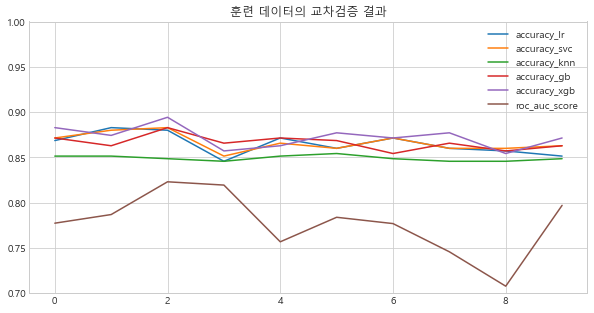

In [59]:
plt.plot( accuracy1 , label='accuracy_lr')
plt.plot( accuracy2 , label='accuracy_svc')
plt.plot( accuracy3 , label='accuracy_knn')
plt.plot( accuracy4 , label='accuracy_gb')
plt.plot( accuracy5 , label='accuracy_xgb')
plt.ylim(0.7,1.0)
plt.legend()
plt.title( '훈련 데이터의 교차검증 결과')
plt.show()

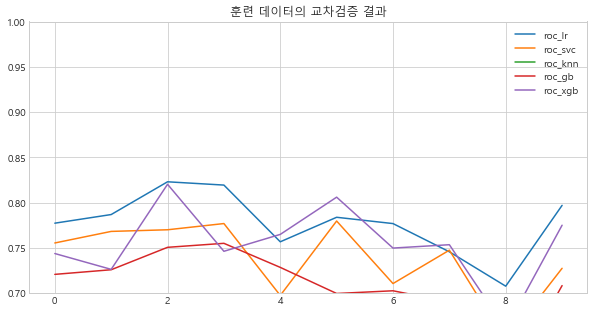

In [60]:
# 훈련용 데이터의 교차검증

roc1 = cross_val_score(gridmodel_lr.best_estimator_, X_train, y_train, scoring='roc_auc', cv=fold1 )
roc2 = cross_val_score(gridmodel_svc.best_estimator_, X_train, y_train, scoring='roc_auc', cv=fold1 )
roc3 = cross_val_score(gridmodel_knn.best_estimator_, X_train, y_train, scoring='roc_auc', cv=fold1 )
roc4 = cross_val_score(gridmodel_gb.best_estimator_, X_train, y_train, scoring='roc_auc', cv=fold1 )
roc5 = cross_val_score(gridmodel_xgb.best_estimator_, X_train, y_train, scoring='roc_auc', cv=fold1 )


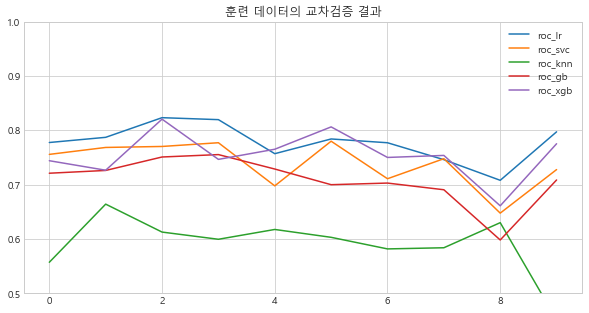

In [62]:

plt.plot( roc1 , label='roc_lr')
plt.plot( roc2 , label='roc_svc')
plt.plot( roc3 , label='roc_knn')
plt.plot( roc4 , label='roc_gb')
plt.plot( roc5 , label='roc_xgb')
plt.ylim(0.5,1.0)
plt.legend()
plt.title( '훈련 데이터의 교차검증 결과')
plt.show()